In [81]:
import scipy.integrate
import numpy
import matplotlib.pyplot
import os
import json
import scipy.interpolate

def dfdy(t,y,system):
    dfdy=system.M.dot(y)+system.u(t)
    return dfdy

def jacobi(t,y,system):
    return system.M

#SE post calculation
def dfdyS(t,S,system):
    #unwrap S to NxM where M is number of parameters
    mS=numpy.reshape(S,(system.n,system.m))
    mOut=system.M.dot(mS)+system.fS(t)
    return numpy.ravel(mOut)

def jacobiSE(t,S,system):
    N=system.n*(system.m)
    fJ=numpy.zeros((N,N))
    #print('fJ shape {}'.format(fJ.shape))
    for i in range(system.m):
        fJ[i*system.n:(i+1)*system.n,i*system.n:(i+1)*system.n]=system.M
    return fJ

#SE simultaeneous calculation
def dfdySFull(t,S,system):
    #unwrap S to NxM where M is number of parameters
    mS=numpy.reshape(S,(system.n,system.m+1))
    #system.fS(y,t) is NxM matrix where M are parameters
    y=mS[:,0]
    mOut=system.M.dot(mS)+system.fSY(y,t)
    return numpy.ravel(mOut)

def jacobiSEFull(t,S,system):
    N=system.n*(system.m+1)
    fJ=numpy.zeros((N,N))
    #print('fJ shape {}'.format(fJ.shape))
    for i in range(system.m+1):
        fJ[i*system.n:(i+1)*system.n,i*system.n:(i+1)*system.n]=system.M
    return fJ

class model:
    def __init__(self):
        self.compartments={}
        self.seJ={}
        
    def add_source(self,compartmentName,formula):
        self.compartments[compartmentName]['source']=formula

    def add_compartment(self,compartmentName):
        self.compartments[compartmentName]={}
        self.compartments[compartmentName]['targets']={}
        self.compartments[compartmentName]['sensTargets']={}

    def bind(self,sourceCompartment,targetCompartment,k,pc,scaleToVolume=0):
        #establish a flow from one compartment to the other
        cSrc=self.compartments[sourceCompartment]
        cTarg=self.compartments[targetCompartment]
        
        vSPar=self.getVolumePar(sourceCompartment,scaleToVolume)
        vTPar=self.getVolumePar(targetCompartment,scaleToVolume)
        
        #the source equation (where we subtract the current)
        addValue(cSrc['targets'],sourceCompartment,-get(k)/get(pc)/get(vSPar))
        #the target equation (where we add the current)
        addValue(cTarg['targets'],sourceCompartment,get(k)/get(pc)/get(vTPar))
        
                    
    def getDerivative(self,variable, sign, qPar, pcPar, vPar):
        
        #for flow based transfer, k=Q/vS/pc, and jacobian derivative is -Q/V/pc/pc
        #for diffusion dominated transfer, k=k1/pc
        q=get(qPar)
        pc=get(pcPar)
        v=get(vPar)
        if variable=="partitionCoefficient":
            return sign*(-1)*q/v/pc/pc
        if variable=="diffusionCoefficient":
            return sign/pc/v
        if variable=="flow":
            return sign/pc/v
        if variable=="volume":
            return sign*(-1)*q/pc/v/v
            
    def getVolumePar(self,compartment,useVolume=1):
        if not useVolume:
            return {"value":1}
        try:
            parVName=self.mod["volumes"][compartment]
            parV=self.mod["parameters"][parVName]
        except KeyError:
            return {"value":1}
        
        parV["name"]=parVName
        return parV
    
    def bindDerivative(self,parameterName,variable,src,target,q,pc,useVolume=1):
        parName=parameterName
        srcV=self.getVolumePar(src,useVolume)
        doAdd=(variable!="volume" or calculateDerivative(srcV))
            
        if doAdd:
            #the source equation (where we subtract the current)
            if variable=="volume":
                parName=srcV["name"]
        
            csrc=self.getSEJ_comp(parName,src)
            addValue(csrc,src,self.getDerivative(variable,-1,q,pc,srcV))
        
        targetV=self.getVolumePar(target,useVolume)
        doAdd=(variable!="volume" or calculateDerivative(targetV))
        
        #the target equation (where we add the current)
        if doAdd:
            if variable=="volume":
                parName=targetV["name"]

            ctarget=self.getSEJ_comp(parName,target)
            addValue(ctarget,src,self.getDerivative(variable,+1,q,pc,targetV))
        
        
        
    def build(self):
        comps=self.compartments
        self.n=len(comps)
        self.M=numpy.zeros((self.n,self.n))
        self.fu=[lambda t:0]*self.n
        self.lut={c:i for (i,c) in zip(range(self.n),comps.keys())}
        for c in comps:
            comp=comps[c]
            if 'source' in comp:
                self.fu[self.lut[c]]=parseFunction(comp['source'])
                               
            for t in comp['targets']:
                self.M[self.lut[c],self.lut[t]]=comp['targets'][t]
        #build SE part
        self.m=len(self.seJ)
        #MxNxN matrix
        self.lutSE={c:i for (i,c) in zip(range(self.m),self.seJ.keys())}
        self.fSS=numpy.zeros((self.m,self.n,self.n))
        for par in self.seJ:
            sources=self.seJ[par]
            for compartment in sources:
                targets=sources[compartment]
                for t in targets:
                    #print('FSS: Adding {}/{},{}/{},{}/{}:{}'.\
                    #      format(par,self.lutSE[par],compartment,self.lut[compartment],t,self.lut[t],targets[t]))
                    self.fSS[self.lutSE[par],self.lut[compartment],self.lut[t]]=targets[t]
        
                      
        
        #print('Done')
    
    def inspect(self):
        comps=self.compartments
        pars=self.mod['parameters']
        print('Compartments')
        for c in comps:
            print('{}/{}:'.format(c,self.lut[c]))
            comp=comps[c]
            if 'source' in comp:
                print('\tsource\n\t\t{}'.format(comp['source']))
            print('\ttargets')
            for t in comp['targets']:
                print('\t\t{}[{},{}]: {}'.format(t,self.lut[c],self.lut[t],comp['targets'][t]))
        print('Flows')
        for f in self.flows:
            fName=self.flows[f]
            fParName=self.mod['flows'][fName]
            fPar=pars[fParName]
            print('\t{}[{}]:{} [{}]'.format(f,fName,fParName,get(fPar)))
        
        print('Volumes')
        for v in self.mod['volumes']:
            vParName=self.mod['volumes'][v]
            vPar=pars[vParName]
            print('\t{}:{} [{}]'.format(v,vParName,get(vPar)))
        
        print('Partition coefficients')
        for pc in self.mod['partitionCoefficients']:
            pcParName=self.mod['partitionCoefficients'][pc]
            pcPar=pars[pcParName]
            print('\t{}:{} [{}]'.format(pc,pcParName,get(pcPar)))
        
        
        print('SE parameters')
        for p in self.seJ:
            print(p)
            sources=self.seJ[p]
            for compartment in sources:
                targets=sources[compartment]
                for t in targets:
                    print('\t SE bind {}/{}:{}'.format(compartment,t,targets[t]))
        #print('Done')
    
    def parse(self,file):
                    
        with open(file,'r') as f:
            self.mod=json.load(f)
        for m in self.mod['compartments']:
            self.add_compartment(m)
        for s in self.mod['sources']:
            #src=mod['sources'][s]
            self.add_source(s,self.mod['sources'][s])
        self.flows={}
        pars=self.mod['parameters']
        for f in self.mod['flows']:
            #skip comments
            if f.find(':')<0:
                continue
            
            comps=f.split(':')
            c0=splitVector(comps[0])
            c1=splitVector(comps[1])
            for x in c0:
                for y in c1:
                    pairName='{}:{}'.format(x,y)
                    self.flows[pairName]=f
                    
        for b in self.mod['bindings']['diffusion']:
            comps=b.split('->')
            try:
                pcParName=self.mod['partitionCoefficients'][b]
                pcPar=pars[pcParName]
            except KeyError:
                pcPar={"value":1}
            
            kParName=self.mod['bindings']['diffusion'][b]
            kPar=pars[kParName]
            self.bind(comps[0],comps[1],kPar,pcPar)
            
            #add derivatives calculateDerivative returns true
            if calculateDerivative(kPar):
                self.bindDerivative(kParName,"diffusionParameter",comps[0],comps[1],kPar,pcPar,0)
            if calculateDerivative(pcPar):
                self.bindDerivative(pcParName,"partitionCoefficient",comps[0],comps[1],kPar,pcPar,0)
            
        for q in self.mod['bindings']['flow']:
            comps=q.split('->')
            srcs=splitVector(comps[0])
            tgts=splitVector(comps[1])
            for cs in srcs:
                for ct in tgts:
                    #get partition coefficient
                    try:
                        pcParName=self.mod['partitionCoefficients'][cs]
                        pcPar=pars[pcParName]
                    except KeyError:
                        pcPar={"value":1}
                    
                    #get flow (direction could be reversed)
                    try:
                        qName=self.flows['{}:{}'.format(cs,ct)]
                    except KeyError:
                        qName=self.flows['{}:{}'.format(ct,cs)]
                    
                    flowParName=self.mod['flows'][qName]
                    flowPar=pars[flowParName]
                    
                    self.bind(cs,ct,flowPar,pcPar,1)
                    
                    if calculateDerivative(pcPar):
                        self.bindDerivative(pcParName,"partitionCoefficient",cs,ct,flowPar,pcPar)
                    if calculateDerivative(flowPar):
                        self.bindDerivative(flowParName,"flow",cs,ct,flowPar,pcPar)
                    self.bindDerivative("x","volume",cs,ct,flowPar,pcPar)
                         
                    #print('bind: {}:(q={},vt={},pc={}):{}'.format(bind,q,vt,pc,q/vt/pc))
                
        self.build()
        
    def u(self,t):
        ub=[f(t) for f in self.fu]
        return numpy.array(ub)
                     
    def fSY(self,y,t):
        #M number of sensitivity parameters
        #N number of equations
        #fSS is MxNxN
        
        #assume a tabulated solution y(t) at t spaced intervals
        
        qS=self.fSS.dot(y)
        #qS is MxN
        #but NxM is expected, so do a transpose
        
        #for simultaneous calculation, a Nx(M+1) matrix is expected
        tS=numpy.zeros((self.n,self.m+1))
        #columns from 2..M+1 are the partial derivatives 
        tS[:,1:]=numpy.transpose(qS)
        #first column is the original function
        tS[:,0]=self.u(t)
        return tS
    
    def fS(self,t):
        #M number of sensitivity parameters
        #N number of equations
        #fSS is MxNxN
        
        #assume a tabulated solution y(t) at t spaced intervals
        
        qS=self.fSS.dot(self.getY(t))
        return numpy.transpose(qS)
                     
    def getSEJ(self,parName):
        #find the sensitivity (SE) derivative of Jacobi with respect to parameter  
        try:
            return self.seJ[parName]
        except KeyError:
            self.seJ[parName]={}
            return self.seJ[parName]
    
    def getSEJ_comp(self,parName,compartmentName):
        #find equation dictating concentration in compartmentName for jacobi-parameter derivative
        seJ=self.getSEJ(parName)
        
        try:
            return seJ[compartmentName]
        except KeyError:
            seJ[compartmentName]={}
            return seJ[compartmentName]
    def setY(self,t,y):
        self.tck=[None]*self.n
        for i in range(self.n):
            self.tck[i] = scipy.interpolate.splrep(t, y[:,i], s=0)
    
    def getY(self,t):
        fY=numpy.zeros(self.n)
        for i in range(self.n):
            fY[i]=scipy.interpolate.splev(t, self.tck[i], der=0)
        return fY
    
    def calculateUncertainty(self,sol,se):
        s2out=numpy.zeros(sol.shape)
        pars=self.mod['parameters']
        for parName in pars:
            par=pars[parName]
            if not calculateDerivative(par):
                continue
            v=par["value"]
            if par['dist']=='lognormal':
                #this is sigma^2_lnx
                sln2=numpy.log(par["cv"]*par["cv"]+1)
                #have to multiplied by value to get the derivative with respect to lnx
                s2=sln2*v*v
            else:
                #for Gaussian, cv is sigma/value; get sigma by value multiplication
                s2=par["cv"]*par["cv"]*v*v
            j=self.lutSE[parName]
            fse=se[:,:,j]
            print('Calculating for {}/{}:{}'.format(parName,j,fse.shape))
            #se2 is nt x n
            se2=numpy.multiply(fse,fse)
            s2out+=se2*s2
        return numpy.sqrt(s2out)
        
def splitVector(v):
    if v.find('(')<0:
        return [v]
    return v[1:-1].split(',')

def parseFunction(formula):
    if formula['name']=='exponential':
        c0=formula['constant']
        k=formula['k']
        return lambda t:c0*numpy.exp(k*t)
    if formula['name']=='constant':
        c0=formula['value']
        return lambda t:c0
    if formula['name']=='Heavyside':
        t0=formula['limit']
        v=formula['value']
        return lambda t:v if t<t0 else 0
    return lambda t:1

def addValue(qdict,compName,v):
    #add real number v to attribute compName of dictionary qdict, check if compName exists and handle the potential error
    try:
        qdict[compName]+=v
    except KeyError:
        qdict[compName]=v

def get(par):
    v=par["value"]
    #convert to seconds
    try:
        if par['unit'].split('/')[1]=='min':
            return v/60
    except (KeyError,IndexError):
        pass
    
    return v

def calculateDerivative(par):
    #add derivatives if dist(short for distribution) is specified
    return "dist" in par

In [109]:
sys=model()
fh=os.path.expanduser('~')
#sys.parse(os.path.join(fh,'software','src','Integra','models','cDiazepam.json'))
sys.parse(os.path.join(fh,'software','src','Integra','models','cCotinine.json'))
#print(sys.u(10)[sys.lut['venous']])
#sys.inspect()         
nt=201
tmax=4*3600
t = numpy.linspace(0,tmax, nt)
#first column is the solution y
#initial condition
y0=numpy.zeros(sys.n)
    
doSequential=0
doSimultaneous=0
doIVP=0
doIVPSimultaneous=1

if doSequential:
#sequential SE (first true solution, then parameter derivatives)
    y0=numpy.zeros(sys.n)
    sol = scipy.integrate.odeint(dfdy, y0=y0, t=t, args=(sys,),Dfun=jacobi,tfirst=True)
    print('shape (y) {}'.format(sol.shape))
    
    #solLSODA = scipy.integrate.LSODA(dfdy,y0,0,tbound=4*3600,min_step=10,max_step=1000,jac=jacobi)
    #sol=solLSODA.
    sys.setY(t,sol)
    S0=numpy.zeros((sys.n,sys.m))
    S0=S0.ravel()
    #print('lut {}'.format(sys.lut))
    #print('lutSE {}'.format(sys.lutSE))
    #fJ=sys.fSS[sys.lutSE['brainPC']]
    #print('X shape {}\n {}'.format(fJ.shape,fJ))
    solSE=scipy.integrate.odeint(dfdyS, S0, t, args=(sys,),Dfun=jacobiSE,tfirst=True)
    s1=numpy.reshape(solSE,(len(t),sys.n,sys.m))
    print('Done sequential SE')
    

if doSimultaneous:
#simultaneous SE
    S1=numpy.zeros((sys.n,sys.m+1))
    #set initial condition
    S1[:,0]=y0
    S1=S1.ravel()
    solSE1=scipy.integrate.odeint(dfdySFull, S1, t, args=(sys,),Dfun=jacobiSEFull,tfirst=True)
    sFull=numpy.reshape(solSE1,(len(t),sys.n,sys.m+1))
    s1=sFull[:,:,1:]
    sol=sFull[:,:,0]
    print('Done simultaneous SE')

if doIVP:
    solIVP=scipy.integrate.solve_ivp(dfdy,[0, tmax],y0, args=(sys,), jac=jacobi,
                                  method='LSODA', atol=1e-4, rtol=1e-8)
    #y is n x nt (odeint nt x n)
    sol=numpy.transpose(solIVP.y)
    t=solIVP.t
    print('shape (y) {}'.format(sol.shape))
    sys.setY(t,sol)
    solIVPSE=scipy.integrate.solve_ivp(dfdyS,[0, tmax],S0, args=(sys,), jac=jacobiSE,
                                  method='LSODA', atol=1e-4, rtol=1e-8)
    sraw=numpy.reshape(numpy.transpose(solIVPSE.y),(len(solIVPSE.t),sys.n,sys.m))
    #interpolate on t
    s1=numpy.zeros((len(t),sys.n,sys.m))
    for i in range(sys.n):
        for j in range(sys.m):
            tck = scipy.interpolate.splrep(solIVPSE.t, sraw[:,i,j], s=0)
            s1[:,i,j]=scipy.interpolate.splev(t, tck, der=0)
        
if doIVPSimultaneous:
    S1=numpy.zeros((sys.n,sys.m+1))
    #set initial condition
    S1[:,0]=y0
    S1=S1.ravel()
    solIVP1=scipy.integrate.solve_ivp(dfdySFull,[0, tmax],S1, args=(sys,), jac=jacobiSEFull,
                                  method='LSODA', atol=10, rtol=1e-2)
    t=solIVP1.t
    sFull=numpy.reshape(numpy.transpose(solIVP1.y),(len(t),sys.n,sys.m+1))
    s1=sFull[:,:,1:]
    sol=sFull[:,:,0]
    print('Done simultaneous LSODA SE')
    
    
#calculate uncertainty
#s1 is nt x nvar x npar

se=sys.calculateUncertainty(sol,s1)


Done simultaneous LSODA SE
Calculating for adiposePC/0:(73091, 16)
Calculating for brainPC/1:(73091, 16)


(73091, 16, 2)


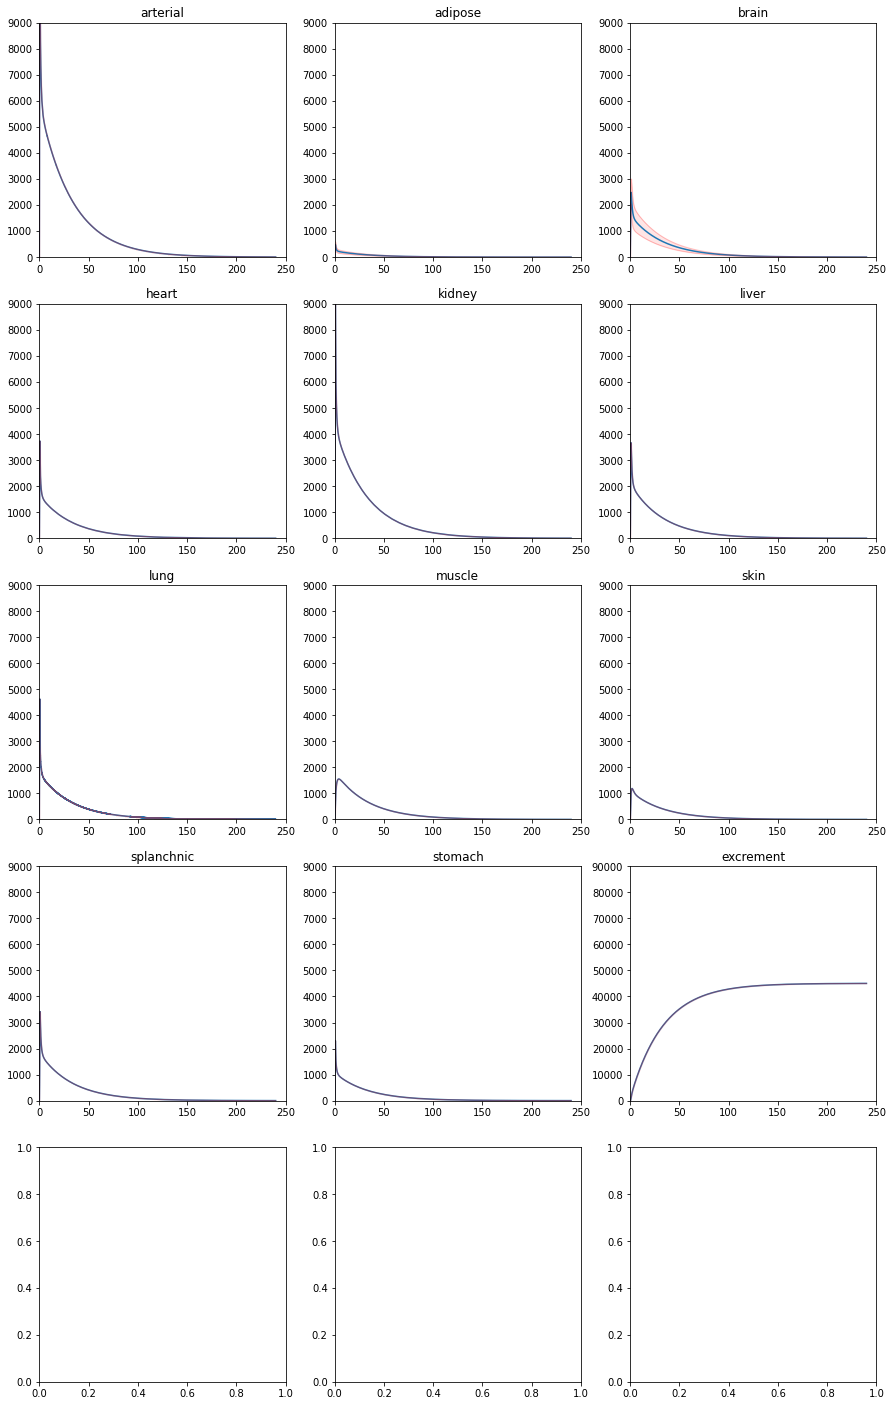

In [110]:
#copy output of Thompson et al
print(s1.shape)
fig, axs = matplotlib.pyplot.subplots(5, 3,figsize=(15,25))
name=['arterial','adipose','brain','heart','kidney','liver','lung','muscle','skin',
      'splanchnic','stomach','excrement']
#diazepam
max=[1.5,2.6,3,4,5,2.5,6.8,1.5,1.5,4,4.2,3]
#cotinine
max=[9]*12
max[11]=90

max=[1000*x for x in max]
for i in range(len(name)):
    row=i//3
    col=i%3
    fy=sol[:,sys.lut[name[i]]]
    fe=se[:,sys.lut[name[i]]]
    ax=axs[row,col]
    ax.plot(t/60,fy)
    ax.fill_between(t/60, fy-fe, fy + fe, color='red',alpha=0.1)
    ax.plot(t/60,fy-fe,color='red',linewidth=1,alpha=0.2)
    ax.plot(t/60,fy+fe,color='red',linewidth=1,alpha=0.2)
    axs[row,col].set_title(name[i])
    axs[row,col].set_ylim([0,max[i]])
    axs[row,col].set_xlim([0,250])


In [89]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1135
     njev: 25
      nlu: 25
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 3.20591951e-04, 6.41183902e-04, 1.28236780e-03,
       1.92355170e-03, 2.56473561e-03, 8.97657462e-03, 1.53884136e-02,
       2.18002527e-02, 2.82120917e-02, 5.40150345e-02, 7.98179774e-02,
       1.05620920e-01, 1.31423863e-01, 1.57226806e-01, 1.99625129e-01,
       2.42023452e-01, 2.84421775e-01, 3.26820098e-01, 3.69218420e-01,
       4.11616743e-01, 4.79107559e-01, 5.46598375e-01, 6.14089191e-01,
       6.81580007e-01, 7.49070823e-01, 8.16561639e-01, 8.84052455e-01,
       9.51550514e-01, 1.01904857e+00, 1.08654663e+00, 1.15404469e+00,
       1.22154275e+00, 1.28904081e+00, 1.35653887e+00, 1.44133130e+00,
       1.52612374e+00, 1.61091617e+00, 1.69570861e+00, 1.78050104e+00,
       1.86529348e+00, 1.96079513e+00, 2.05629678e+00, 2.15179843e+00,
       2.24730008e+00, 2.34280173e+00

In [58]:
fse=s1[:,:,0]
numpy.argwhere(numpy.isnan(fse))
fse[:,0]

array([0.00000000e+000, 9.46314230e+003, 6.45365940e+003, 5.67275261e+003,
       6.26418952e-007, 1.79899429e-007, 1.79899429e-007, 3.22904947e-009,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 5.56433140e+115, 0.00000000e+000, 0.00000000e+000,
                   inf, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 4.49748572e-008, 4.49748572e-008,
       7.19597716e-007, 4.49748572e-008, 4.49748572e-008, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [18]:
M=numpy.ones((3,2,2))
M[0,0,1]=2
M[1,1,0]=3
M[2,1,1]=5
v=numpy.ones(2)
q=M.dot(v)
q1=q.ravel()
q2=numpy.reshape(q1,q.shape)
print(q)
print(q2)

[[3. 2.]
 [2. 4.]
 [2. 6.]]
[[3. 2.]
 [2. 4.]
 [2. 6.]]
